# Data:
## E-commerce customer segmentation and predection 
## Step 1: Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

# For text processing
import nltk
nltk.download('punkt') # Download necessary resource for tokenization
nltk.download('averaged_perceptron_tagger') #Download necessary for pos_tag

# For clustering and evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For dimensionality reduction
from sklearn.decomposition import PCA

# For word clouds
from wordcloud import WordCloud, STOPWORDS

# For interactive plots
import plotly.express as px # Using plotly.express for easier interactive plots

# Suppress warnings
warnings.filterwarnings("ignore")

# Set style for matplotlib plots
plt.style.use('fivethirtyeight')

# Configure Plotly to work offline in Jupyter Notebook
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Use "notebook_connected" for interactive mode


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 2. Data preprocessing

In [61]:
data = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [62]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

In [5]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

* Because this Customer segmentation 'customerID' is crucial for analysis, with missing values in CustomerId the other data is useless so it better the null values


In [6]:
# droping the missing values/rows from the CustomerID 
data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', data.shape)

Dataframe dimensions: (406829, 8)


* After dropping the missing values we 406829 rows and 8 columns 

In [7]:
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
print('Duplicate Entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)
data_cleaned = data.copy()

Duplicate Entries: 5225


* There are 5225 duplicate values we have dropped the duplicate values.

In [9]:
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
data_cleaned['Year'] = data_cleaned['InvoiceDate'].dt.year
data_cleaned['Month'] = data_cleaned['InvoiceDate'].dt.month
data_cleaned['Day'] = data_cleaned['InvoiceDate'].dt.day
data_cleaned['Hour'] = data_cleaned['InvoiceDate'].dt.hour


* Here we have created separate coulmns year,month,day,hour of invoicedate column

In [10]:
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (data_cleaned['UnitPrice'] > 0)]


In [11]:
# Calculate TotalPrice
data_cleaned['TotalPrice'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']


In [12]:
data_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,20.34


In [13]:
temp_cou = data_cleaned[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()

In [14]:
temp_cou

Empty DataFrame
Columns: []
Index: [(12346.0, 541431, United Kingdom), (12347.0, 537626, Iceland), (12347.0, 542237, Iceland), (12347.0, 549222, Iceland), (12347.0, 556201, Iceland), (12347.0, 562032, Iceland), (12347.0, 573511, Iceland), (12347.0, 581180, Iceland), (12348.0, 539318, Finland), (12348.0, 541998, Finland), (12348.0, 548955, Finland), (12348.0, 568172, Finland), (12349.0, 577609, Italy), (12350.0, 543037, Norway), (12352.0, 544156, Norway), (12352.0, 545323, Norway), (12352.0, 545332, Norway), (12352.0, 546869, Norway), (12352.0, 547390, Norway), (12352.0, 567505, Norway), (12352.0, 568699, Norway), (12352.0, 574275, Norway), (12353.0, 553900, Bahrain), (12354.0, 550911, Spain), (12355.0, 552449, Bahrain), (12356.0, 541430, Portugal), (12356.0, 549435, Portugal), (12356.0, 576895, Portugal), (12357.0, 574740, Switzerland), (12358.0, 559707, Austria), (12358.0, 581232, Austria), (12359.0, 540946, Cyprus), (12359.0, 543370, Cyprus), (12359.0, 555477, Cyprus), (12359.0, 571034, Cyprus), (12360.0, 554132, Austria), (12360.0, 563749, Austria), (12360.0, 571705, Austria), (12361.0, 545017, Belgium), (12362.0, 544203, Belgium), (12362.0, 551346, Belgium), (12362.0, 559295, Belgium), (12362.0, 563037, Belgium), (12362.0, 568651, Belgium), (12362.0, 570667, Belgium), (12362.0, 572887, Belgium), (12362.0, 573173, Belgium), (12362.0, 574329, Belgium), (12362.0, 580979, Belgium), (12363.0, 549687, Unspecified), (12363.0, 563947, Unspecified), (12364.0, 563854, Belgium), (12364.0, 567897, Belgium), (12364.0, 573401, Belgium), (12364.0, 580152, Belgium), (12365.0, 544574, Cyprus), (12365.0, 544578, Cyprus), (12367.0, 580716, Denmark), (12370.0, 538826, Cyprus), (12370.0, 539330, Austria), (12370.0, 546236, Cyprus), (12370.0, 571905, Cyprus), (12371.0, 570521, Switzerland), (12371.0, 572770, Switzerland), (12372.0, 544157, Denmark), (12372.0, 552731, Denmark), (12372.0, 568872, Denmark), (12373.0, 542887, Austria), (12374.0, 576345, Austria), (12375.0, 565333, Finland), (12375.0, 579281, Finland), (12377.0, 539488, Switzerland), (12377.0, 542586, Switzerland), (12378.0, 562046, Switzerland), (12379.0, 557789, Belgium), (12379.0, 567196, Belgium), (12380.0, 555739, Belgium), (12380.0, 567928, Belgium), (12380.0, 571187, Belgium), (12380.0, 577180, Belgium), (12381.0, 563100, Norway), (12381.0, 570681, Norway), (12381.0, 570725, Norway), (12381.0, 574694, Norway), (12381.0, 580638, Norway), (12383.0, 539840, Belgium), (12383.0, 540971, Belgium), (12383.0, 546434, Belgium), (12383.0, 550284, Belgium), (12383.0, 555928, Belgium), (12384.0, 562882, Switzerland), (12384.0, 575734, Switzerland), (12386.0, 537676, Australia), (12386.0, 540280, Australia), (12388.0, 541271, Australia), (12388.0, 543357, Australia), (12388.0, 546135, Australia), (12388.0, 560033, Australia), (12388.0, 568145, Australia), (12388.0, 578459, Australia), ...]

[18532 rows x 0 columns]

* Here we have grouped the CustomerID,Invoice,country to know how many invoice are their related to each CustomerID

In [15]:
temp_cou = temp_cou.reset_index(drop = False)

In [16]:
countries = temp_cou['Country'].value_counts()
print('No. of countries in the dataframe: {}'.format(len(countries)))

No. of countries in the dataframe: 37


 * Here we have taken count of the number of unique countries

In [17]:
countries.index

Index(['United Kingdom', 'Germany', 'France', 'EIRE', 'Belgium', 'Netherlands',
       'Spain', 'Portugal', 'Australia', 'Switzerland', 'Finland', 'Italy',
       'Norway', 'Sweden', 'Channel Islands', 'Japan', 'Poland', 'Denmark',
       'Austria', 'Cyprus', 'Unspecified', 'Iceland', 'Singapore', 'Canada',
       'Greece', 'USA', 'Israel', 'Malta', 'European Community', 'Lithuania',
       'United Arab Emirates', 'Czech Republic', 'Bahrain', 'Saudi Arabia',
       'Lebanon', 'Brazil', 'RSA'],
      dtype='object', name='Country')

In [18]:
countries

Country
United Kingdom          16646
Germany                   457
France                    389
EIRE                      260
Belgium                    98
Netherlands                94
Spain                      90
Portugal                   57
Australia                  57
Switzerland                51
Finland                    41
Italy                      38
Norway                     36
Sweden                     36
Channel Islands            26
Japan                      19
Poland                     19
Denmark                    18
Austria                    17
Cyprus                     16
Unspecified                 8
Iceland                     7
Singapore                   7
Canada                      6
Greece                      5
USA                         5
Israel                      5
Malta                       5
European Community          4
Lithuania                   4
United Arab Emirates        3
Czech Republic              2
Bahrain                     2
Sa

In [19]:
len(data_cleaned['CustomerID'].value_counts())

4338

In [20]:
pd.DataFrame([{'products': len(data_cleaned['StockCode'].value_counts()),
               'transactions': len(data_cleaned['InvoiceNo'].value_counts()),
               'customers': len(data_cleaned['CustomerID'].value_counts()),}],
             columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3665,18532,4338


In [21]:
temp_pro = data_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

# Rename the InvoiceDate to number of products
products_per_cart = temp_pro.rename(columns = {'InvoiceDate':'Number of products'})

# Sort in Ascending order based on CustomerID
products_per_cart[:10].sort_values('CustomerID') # List first 10 values

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12347.0,537626,31
2,12347.0,542237,29
3,12347.0,549222,24
4,12347.0,556201,18
5,12347.0,562032,22
6,12347.0,573511,47
7,12347.0,581180,11
8,12348.0,539318,17
9,12348.0,541998,6


 * Here we have renamed the InvoiceDate to number of products and sorted the customerid in accending order


In [22]:
# sum of purchases / user & order
temp_sum = data_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
cart_price = temp_sum.rename(columns = {'TotalPrice':'cart Price'})

# date of the order
data_cleaned['InvoiceDate_int'] = data_cleaned['InvoiceDate'].astype('int64')
temp_date = data_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
data_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
cart_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp_date['InvoiceDate_int'])

# selection of significant entries:
cart_price = cart_price[cart_price['cart Price'] > 0] 
cart_price.sort_values('CustomerID')[:6] 

,CustomerID,InvoiceNo,cart Price,InvoiceDate
0,12346.0,541431,77183.60,2011-01-18 10:01:00.000000000
1,12347.0,537626,711.79,2010-12-07 14:57:00.000000000
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:43:00.000000000
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000000
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000


* Here we have created a column named cart price by total purchase made by each customer according to the invoiceno

In [23]:
cart_price.max(), cart_price.min()

(CustomerID                 18287.0
 InvoiceNo                   581587
 cart Price                168469.6
 InvoiceDate    2011-12-09 12:50:00
 dtype: object,
 CustomerID                 12346.0
 InvoiceNo                   536365
 cart Price                    0.38
 InvoiceDate    2010-12-01 08:26:00
 dtype: object)

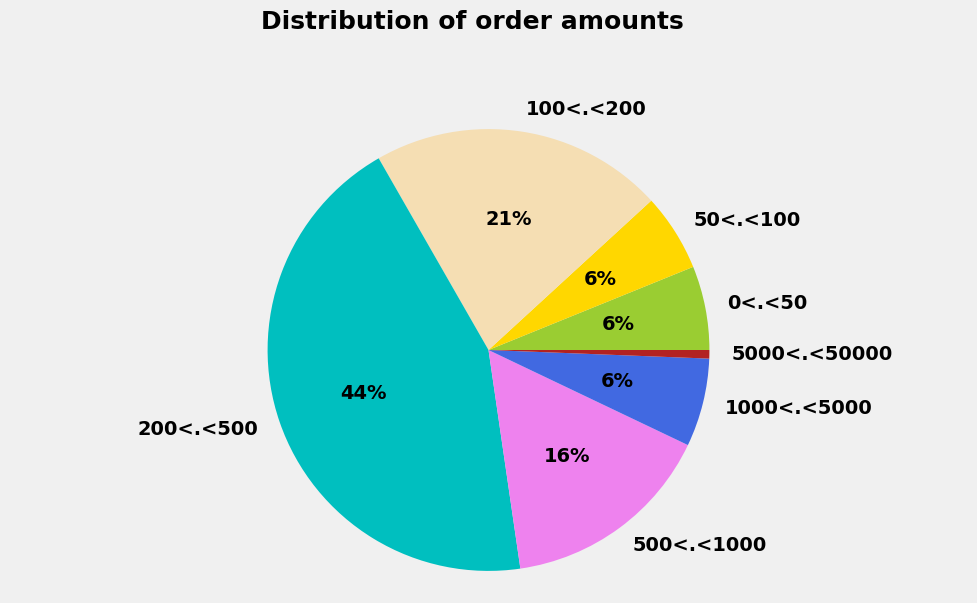

In [24]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]

count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    # Use cart_price instead of basket_price for filtering
    val = cart_price[(cart_price['cart Price'] < price) &
                       (cart_price['cart Price'] > price_range[i-1])]['cart Price'].count()
    count_price.append(val)



# Representation of the number of purchases / amount
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

* This piechart describes the percentage of amounts ranges in different catorgies that defines values of customer and spending of the customer
* There is 44% spending under range of 200-500 dollars
* And 21% under 50-100 dollars
* 16% under 500-1000, that means most of the customers spendings would under 50$-1000$ dollars.


# 3. Exploratory Data Analysis (EDA)

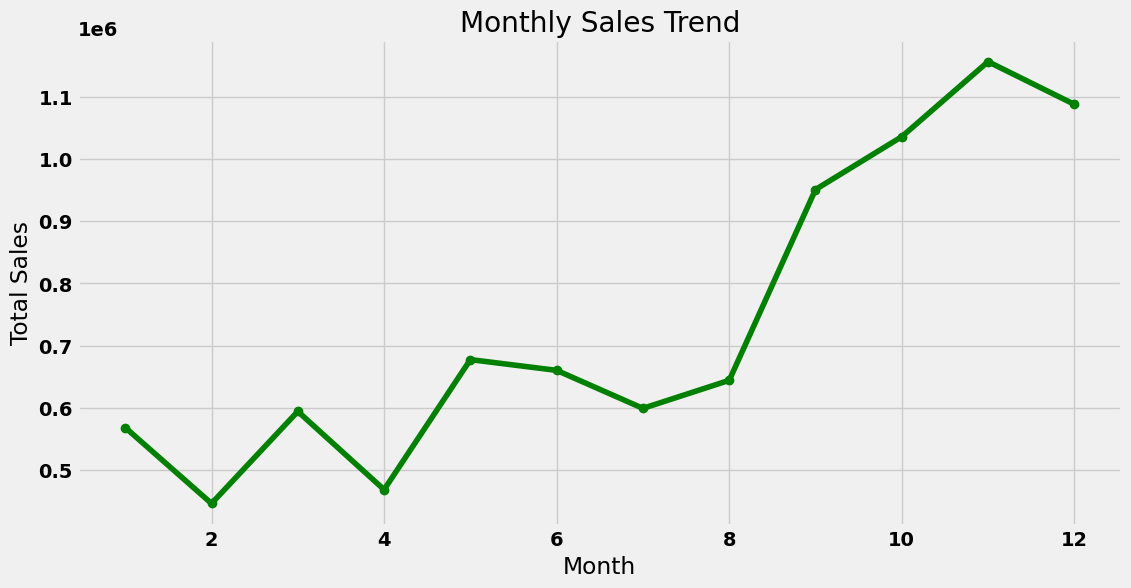

In [25]:
# Monthly sales
monthly_sales = data_cleaned.groupby('Month')['TotalPrice'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='green')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

* In the above graph we can see the sales trend of each month 
* until 8th month there is no increase in the trend but after 8th month we can observe rapid increase in the trend
* That describes that the purchases are very high in the ending 3 months.


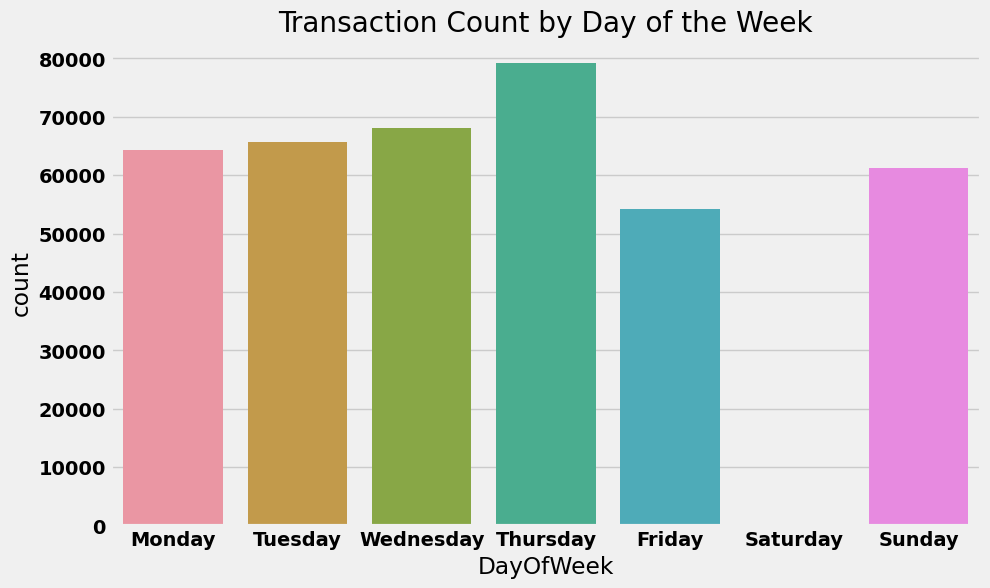

In [26]:
# Day of week analysis
data_cleaned['DayOfWeek'] = data_cleaned['InvoiceDate'].dt.day_name()
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Transaction Count by Day of the Week")
plt.show()


* In the plot we can see the transaction count by days within the week 
* there are highest transactions on thursday and least transactions on saturday


Top 10 products by revenue:
 Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142264.75
WHITE HANGING HEART T-LIGHT HOLDER    100392.10
JUMBO BAG RED RETROSPOT                85040.54
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68785.23
ASSORTED COLOUR BIRD ORNAMENT          56413.03
Manual                                 53419.93
RABBIT NIGHT LIGHT                     51251.24
Name: TotalPrice, dtype: float64


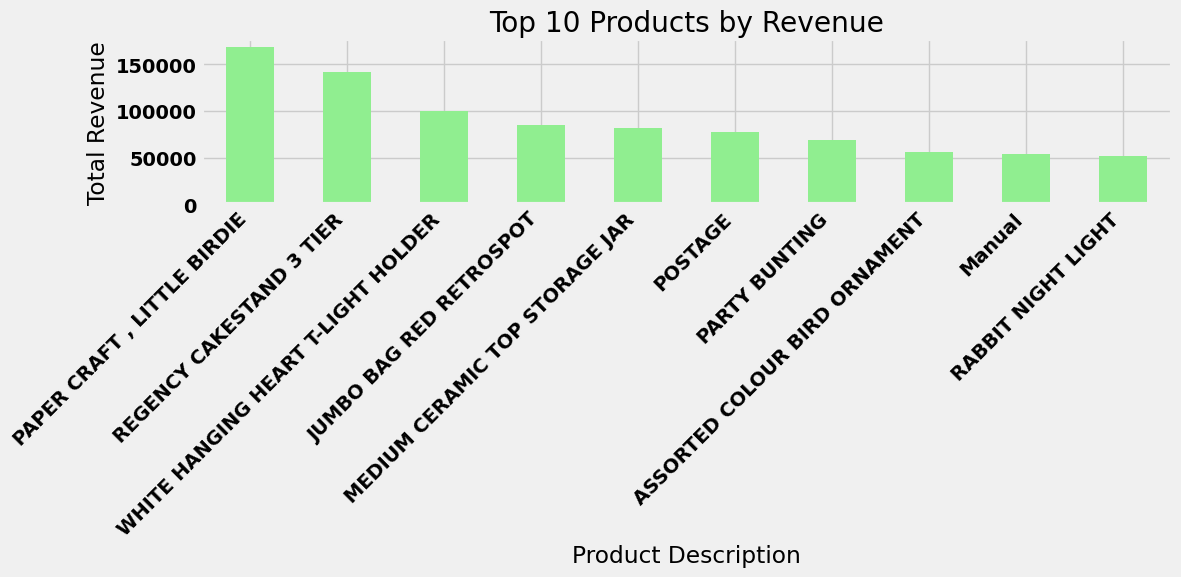

In [27]:

# Calculate and plot top 10 products by revenue
product_revenue = data_cleaned.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
top_revenue_products = product_revenue.head(10)
print("\nTop 10 products by revenue:\n", top_revenue_products)

# Plot top 10 products by revenue
plt.figure(figsize=(12, 6))
top_revenue_products.plot(kind='bar', color='lightgreen')
plt.title("Top 10 Products by Revenue")
plt.xlabel("Product Description")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

* Above plot describes the top 10 selling by revenue

# 4. Customer Segmentation

## Calculating Recency:
* Here we are calculating recency for customers

In [28]:
# Ensure the InvoiceDate column is in datetime format
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])

# Get the most recent date in the dataset
recent_date = data_cleaned['InvoiceDate'].max()

# Group by CustomerID and calculate the LastPurchaseDate and Recency
df_recency = (
    data_cleaned.groupby('CustomerID', as_index=False)['InvoiceDate']
    .max()
    .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)
df_recency['Recency'] = (recent_date - df_recency['LastPurchaseDate']).dt.days

df_recency.head()


,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:01:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


* Recency descreibes how recently has the customer made a transaction

# Calculating Frequency:
* Here We are here calculating the frequency 

In [29]:
frequency_df = data_cleaned.groupby('CustomerID', as_index=False)['InvoiceDate'].nunique().rename(columns={'InvoiceDate': 'Frequency'})
frequency_df.head()



,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


* frequency describes how frequent the customer making the transaction with their orderings

# Calculating Monetary Value:
*Here we are calculating the monetary value of customer



In [30]:
# Calculate TotalPrice
data_cleaned['TotalPrice'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
monetary_df = data_cleaned.groupby(by='CustomerID', as_index=False)['TotalPrice'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()


,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


* Monetary how much does the customer spend on purchasing

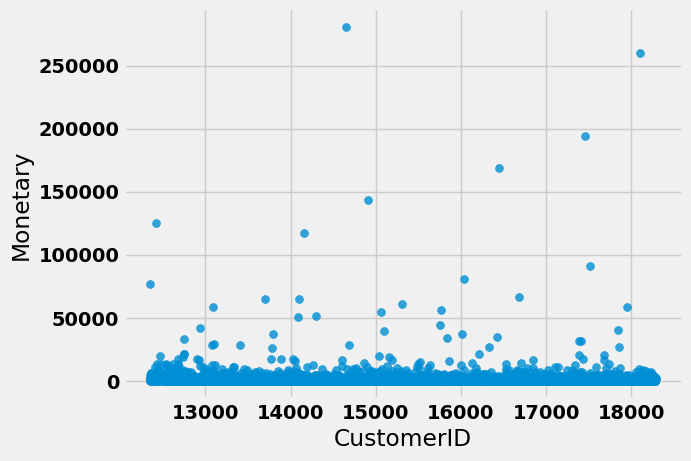

In [31]:
from matplotlib import pyplot as plt
monetary_df.plot(kind='scatter', x='CustomerID', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

* Above scatter plot describes the montery value of the customers based on their represented ID's

# Merging all three columns in one dataframe:
* Here we are merging all the dataframe columns in a single entity using the merge function to display the recency, frequency, monetary value.

In [32]:
# Calculate Recency
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])  # Ensure datetime format
recent_date = data_cleaned['InvoiceDate'].max()
df_recency = data_cleaned.groupby('CustomerID', as_index=False)['InvoiceDate'].max().rename(columns={'InvoiceDate': 'LastPurchaseDate'})
df_recency['Recency'] = (recent_date - df_recency['LastPurchaseDate']).dt.days

# Calculate Frequency
frequency_df = data_cleaned.groupby('CustomerID', as_index=False)['InvoiceDate'].nunique().rename(columns={'InvoiceDate': 'Frequency'})

# Calculate Monetary
data_cleaned['TotalPrice'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
monetary_df = data_cleaned.groupby('CustomerID', as_index=False)['TotalPrice'].sum().rename(columns={'TotalPrice': 'Monetary'})

# Merge Recency, Frequency, and Monetary
rfm_df = df_recency[['CustomerID', 'Recency']].merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

rfm_df.head()



,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


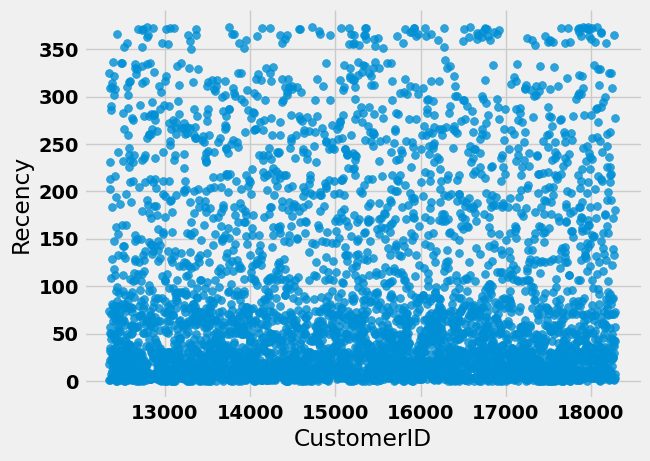

In [33]:
from matplotlib import pyplot as plt
rfm_df.plot(kind='scatter', x='CustomerID', y='Recency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

* Above scatter plot describes the recency of the customer 

# Ranking Customer’s based upon their recency, frequency, and monetary score:
* Here we are normalizing the rank of the customers within a company to analyze the ranking.

In [34]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()


,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,325,1,77183.60,3.751165,17.242969,17.242969
1,12347.0,1,7,4310.00,97.914725,85.580913,85.580913
2,12348.0,74,4,1797.24,38.513514,69.893960,69.893960
3,12349.0,18,1,1757.55,74.137931,17.242969,17.242969
4,12350.0,309,1,334.40,5.370457,17.242969,17.242969


# Calculating RFM score:
* RFM score is calculated based upon recency, frequency, monetary value normalize ranks. Based upon this score we divide our customers.

In [35]:
rfm_df['RFM_Score'] = 0.0075 * rfm_df['R_rank_norm'] + 0.014 * rfm_df['F_rank_norm'] + 0.0285 * rfm_df['M_rank_norm']
rfm_df = rfm_df.round(2)
rfm_df[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,12346.0,0.76
1,12347.0,4.37
2,12348.0,3.26
3,12349.0,1.29
4,12350.0,0.77
5,12352.0,4.19
6,12353.0,0.86


# Rating Customer based upon the RFM score:

In [36]:
bins = [0, 1.6, 3, 4, 4.5, float('inf')]
labels = ['Lost Customers', 'Low Value Customers', 'Medium Value Customer', 'High Value Customer', 'Top Customers']
rfm_df['Customer_segment'] = pd.cut(rfm_df['RFM_Score'], bins=bins, labels=labels, right=False)
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)



,CustomerID,RFM_Score,Customer_segment
0,12346.0,0.76,Lost Customers
1,12347.0,4.37,High Value Customer
2,12348.0,3.26,Medium Value Customer
3,12349.0,1.29,Lost Customers
4,12350.0,0.77,Lost Customers
5,12352.0,4.19,High Value Customer
6,12353.0,0.86,Lost Customers
7,12354.0,0.84,Lost Customers
8,12355.0,0.85,Lost Customers
9,12356.0,3.05,Medium Value Customer


# Visualizing the customer segments:

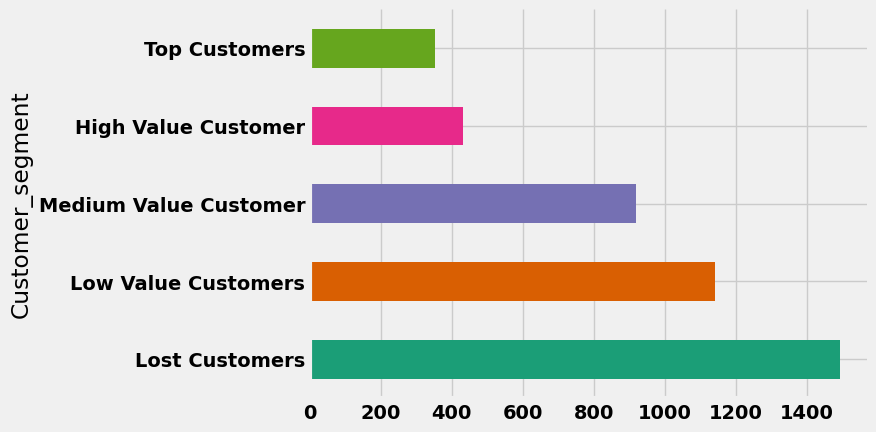

In [37]:

rfm_df.groupby('Customer_segment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


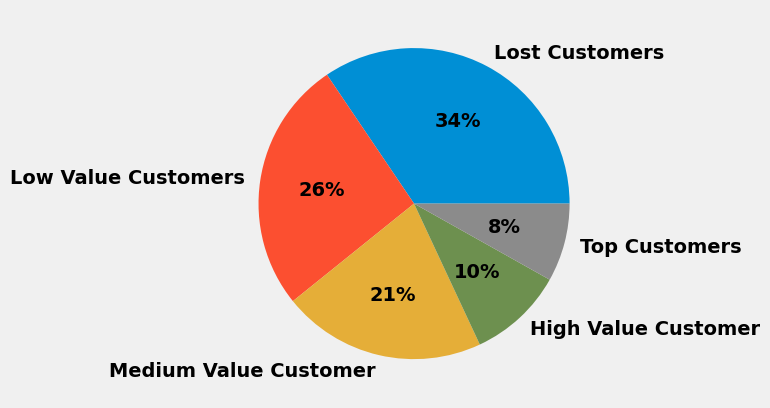

In [38]:
plt.pie(rfm_df.Customer_segment.value_counts(),labels=rfm_df.Customer_segment.value_counts().index,autopct='%.0f%%')
plt.show()



* Above pie plot displays all segments of customers.
* we have 34% lost customers that means these customers are mostly who did single time transactions.
* we have 26% low value customers which represents their monetary value is low.
* we have 21% medium value customers which represents they are frequently purchasing but they have medium monetary value. 
* we have 10% high value customers which represents they are most frquently purchasing and their monetary value is high.
* And at last we have 8% high value customers who monetary is very high

# Importing standardscaler:
* Here we have standardized Recency, Frequency, and Monetary

In [40]:
from sklearn.preprocessing import StandardScaler

# Standardize Recency, Frequency, and Monetary
rfm_df[['Recency', 'Frequency', 'Monetary']] = StandardScaler().fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

rfm_df.head()


,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,Cluster
0,12346.0,2.334574,-0.425815,8.363010,3.75,17.24,17.24,0.76,Lost Customers,2
1,12347.0,-0.905340,0.360110,0.251699,97.91,85.58,85.58,4.37,High Value Customer,0
2,12348.0,-0.175360,-0.032853,-0.027988,38.51,69.89,69.89,3.26,Medium Value Customer,0
3,12349.0,-0.735345,-0.425815,-0.032406,74.14,17.24,17.24,1.29,Lost Customers,0
4,12350.0,2.174578,-0.425815,-0.190812,5.37,17.24,17.24,0.77,Lost Customers,0


# K-Means clustering:
* Applying k-means clustering

In [41]:
from sklearn.cluster import KMeans

# Apply KMeans clustering and assign cluster labels
rfm_df['Cluster'] = KMeans(n_clusters=5, random_state=42).fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Analyze clusters
print(rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())


          Recency  Frequency   Monetary
Cluster                                
0       -0.759907   1.673668   0.739366
1        1.563981  -0.353704  -0.170505
2       -0.865341  10.184164   6.179529
3       -0.853342   4.577904  22.648612
4       -0.474671  -0.121560  -0.093404


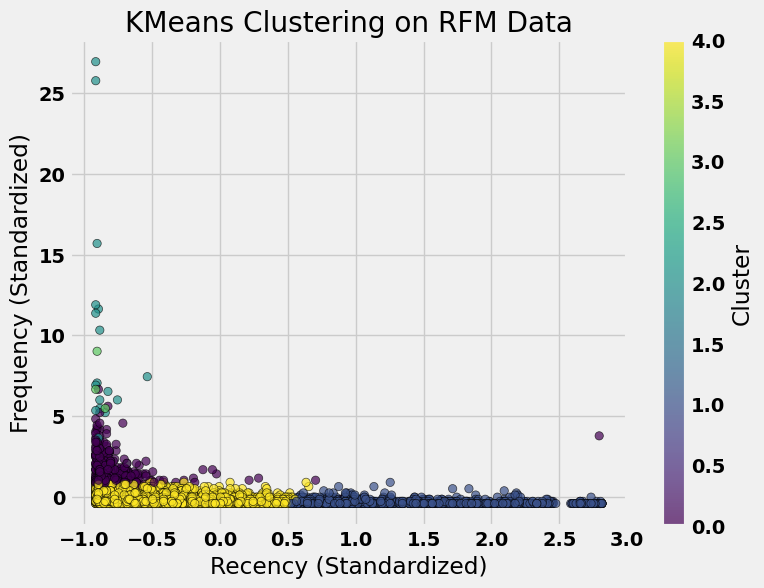

In [43]:

# Plot KMeans Clustering Result
plt.figure(figsize=(8, 6))
plt.scatter(
    rfm_df['Recency'], rfm_df['Frequency'], 
    c=rfm_df['Cluster'], cmap='viridis', alpha=0.7, edgecolors='k'
)
plt.title('KMeans Clustering on RFM Data')
plt.xlabel('Recency (Standardized)')
plt.ylabel('Frequency (Standardized)')
plt.colorbar(label='Cluster')
plt.show()

* Above plot describes the clustered data points of the RFM data 

# Principal Component Analysis(PCA):
* Here we have applied pca 

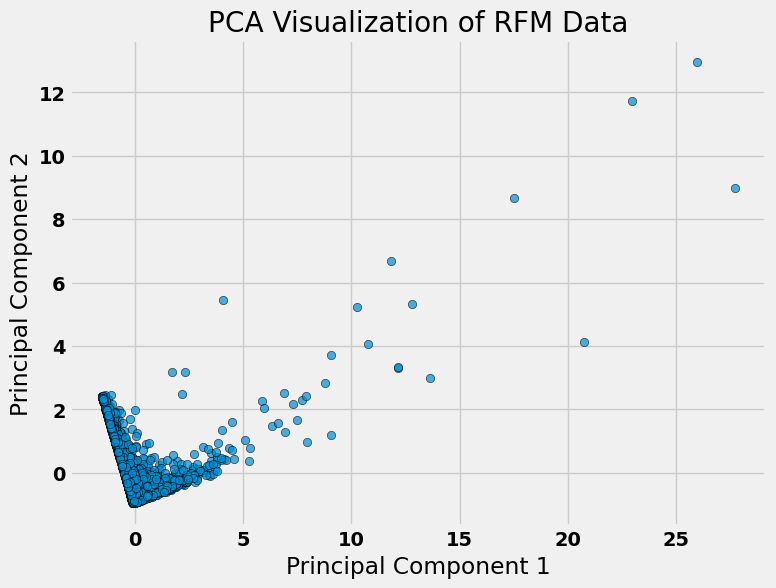

In [42]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Plot the PCA result without clustering information
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolors='k')
plt.title('PCA Visualization of RFM Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


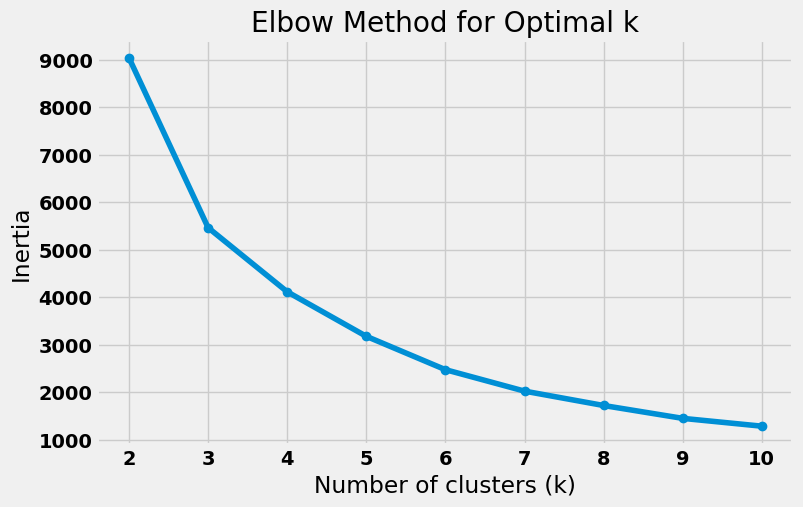

In [44]:
# Determine the optimal number of clusters using the Elbow Method
k_range = range(2, 11)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


* Above plot represents elbow curve of k-means clustering which determines to check valid k point

Inertia values:
2 : 9036.345192500205
3 : 5462.6409114471135
4 : 4112.803975269492
5 : 3175.198357616706
6 : 2473.153543599041
7 : 2021.5549616936664
8 : 1718.92844087049
9 : 1448.1318788167478
10 : 1283.5736982160956


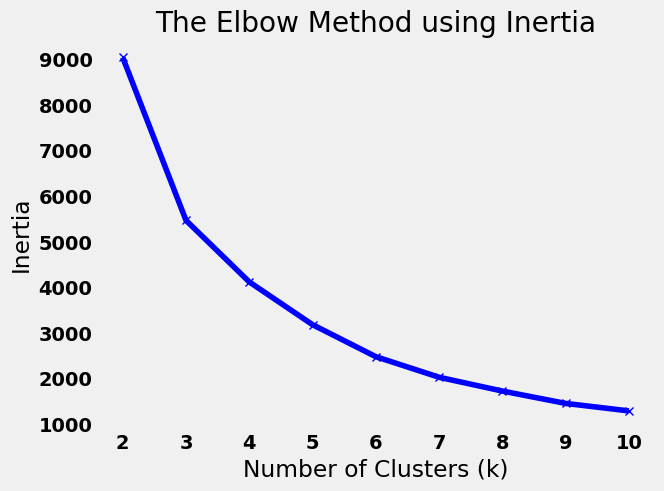

In [47]:
print("Inertia values:")

# Create the mapping2 dictionary (assuming it should store k and inertia values)
mapping2 = dict(zip(k_range, inertia))  # Assuming k_range and inertia are from previous cell

for key, val in mapping2.items():
    print(f'{key} : {val}')

# Plotting the graph of k versus Inertia (using k_range and inertia)
plt.plot(k_range, inertia, 'bx-')  # Use k_range and inertia here
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()
plt.show()

* This plots and represents the clusters and interia of the clusters

In [49]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming rfm_df is already created and standardized as in your provided code
# ... (Your previous code for loading, preprocessing, and creating rfm_df) ...

# Feature Importance from KMeans Clustering

# Standardize the features if not already done
rfm_df[['Recency', 'Frequency', 'Monetary']] = StandardScaler().fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])


# Apply KMeans clustering with a suitable number of clusters
kmeans = KMeans(n_clusters=5, random_state=42) # Example: 5 clusters
rfm_df['Cluster'] = kmeans.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Get feature importances from the fitted KMeans model (inertia reduction)
feature_importances = abs(kmeans.cluster_centers_) #Absolute values of cluster center coordinates

# Create a DataFrame to visualize feature importances
importance_df = pd.DataFrame(feature_importances, columns=['Recency', 'Frequency', 'Monetary'])
importance_df['Cluster'] = range(len(importance_df))
importance_df = importance_df.melt(id_vars='Cluster', var_name='Feature', value_name='Importance')
importance_df

,Cluster,Feature,Importance
0,0,Recency,0.481820
1,1,Recency,0.848675
2,2,Recency,1.569362
3,3,Recency,0.905340
4,4,Recency,0.762814
5,0,Frequency,0.081881
6,1,Frequency,3.261072
7,2,Frequency,0.279926
8,3,Frequency,24.954328
9,4,Frequency,1.700988


# DB Scan Clustering:
* Here we have applied DB scan clustering

In [51]:

from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5) # You can adjust eps and min_samples
rfm_df['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Analyze the clusters
print(rfm_df.groupby('DBSCAN_Cluster')[['Recency', 'Frequency', 'Monetary']].mean())



                 Recency  Frequency  Monetary
DBSCAN_Cluster                               
-1             -0.464006   5.027795  5.923212
 0              0.006687  -0.066081 -0.072643
 1             -0.899340   4.289732  0.595682


# 5. Predictive Classifier

In [57]:
# Apply KMeans clustering with a suitable number of clusters
kmeans = KMeans(n_clusters=5, random_state=42) # Example: 5 clusters
rfm_df['Cluster'] = kmeans.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Get feature importances from the fitted KMeans model (inertia reduction)
feature_importances = abs(kmeans.cluster_centers_) #Absolute values of cluster center coordinates

# Create a DataFrame to visualize feature importances
importance_df = pd.DataFrame(feature_importances, columns=['Recency', 'Frequency', 'Monetary'])
importance_df['Cluster'] = range(len(importance_df))
importance_df = importance_df.melt(id_vars='Cluster', var_name='Feature', value_name='Importance')

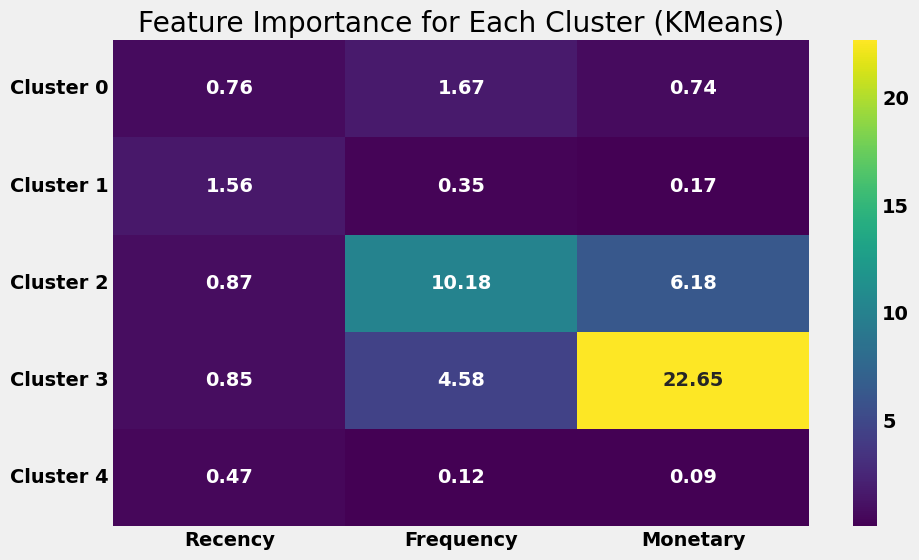

In [58]:
# Visualize feature importances using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importances, annot=True, cmap='viridis', fmt=".2f", 
            xticklabels=['Recency', 'Frequency', 'Monetary'], 
            yticklabels=[f'Cluster {i}' for i in range(kmeans.n_clusters)])
plt.title('Feature Importance for Each Cluster (KMeans)')
plt.show()


* Above graph describes future importance through a heatmap 

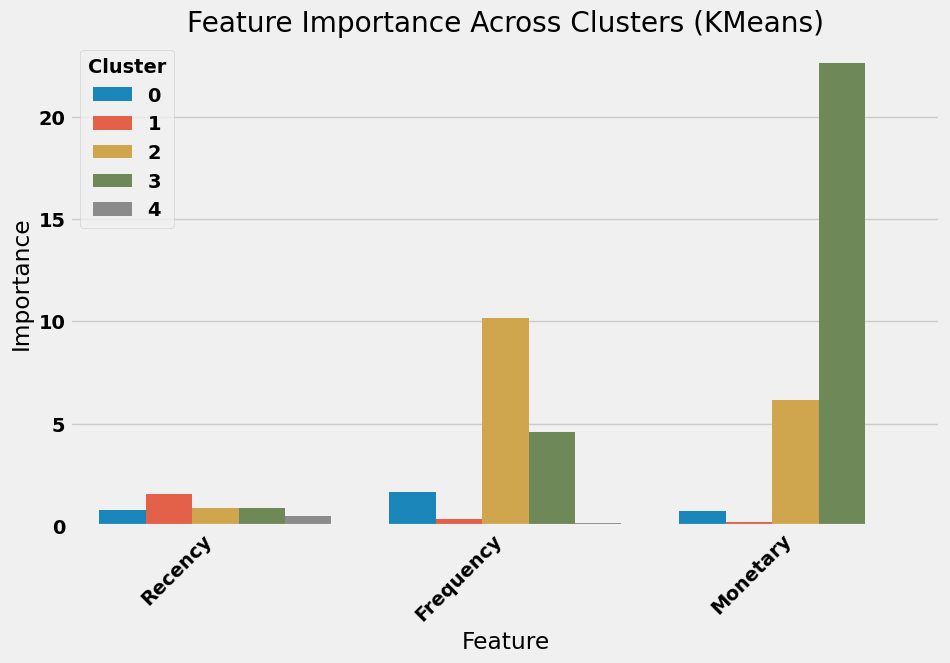

In [59]:

# Alternatively, visualize with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', hue='Cluster', data=importance_df)
plt.title('Feature Importance Across Clusters (KMeans)')
plt.xticks(rotation=45, ha='right')
plt.show()

* Above graph describes the feature importance through a barplot